# 08 - Conditional Normalizing Flow for Joint and Conditional sampling. 
This notebook is the second in the tutorial series for InvertibleNetworks.jl. In this tutorial, we will show how to train a Normalizing Flow (NF) to sample from a joint distribution $p(x,y)$. Pairing joint distribution training with conditional normalizing flows allows us to sample from the conditional distribution and therefore the posterior distribution of an inverse problem. We will use the conditional normalizing flow architecture given by [HINT (Kruse, Jakob, et al.)](https://arxiv.org/pdf/1905.10687.pdf).

The HINT architecture implements:
* HINT recursive couplying layer for increased expressiveness
* HINT conditional couplying layer for conditional samplying
* Other layers: ActNorms, 1x1 Convolutions




In [ ]:
import Pkg; Pkg.develop("InvertibleNetworks") #note only need to run once to install
import Pkg; Pkg.add("Flux")                   #note only need to run once to install

In [ ]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot
using Flux
using Random

PyPlot.rc("font", family="serif"); 

# Prior distribution - Rosenbrock

In [19]:
nx = 1
ny = 1
n_in = 2
n_train = 60000;
X_train = sample_banana(n_train);
size(X_train) #(nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channels

(1, 1, 2, 60000)

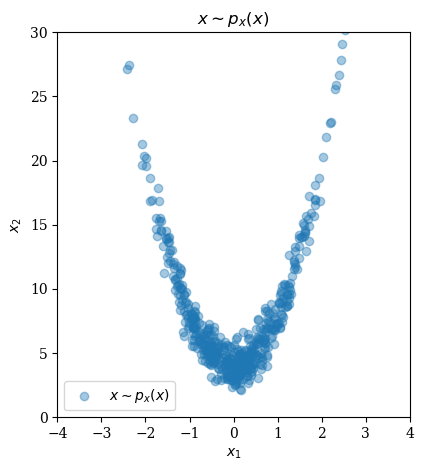

In [20]:
plot_num = 500

fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p_x(x)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{x}(x)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

# Linear inverse problem with Gaussian additive noise

As a stylized example, we will solve an inverse problem given linear measurements of a model $x$ through a compressive sensing operator $A$. We will also add gaussian additive noise and the result will be our observed data.   
$$y = Ax + \epsilon$$

Even though we will chose an $A$ that will be invertible, the added noise makes this problem ill-posed. Therefore for a given datapoint $y$ there is not a single model $x$ which solves the inverse problem. Instead there is a whole distribution of models $p(x|y)$, the conditional distribution. In this context, this is also called the posterior distribution. 

Note: we could also use a non-linear operator.

First we make an our linear measurement operator:

In [5]:
# Random seed
Random.seed!(8)

# Linear forward operator
A = randn(Float32,2,2)
A = A / (2*opnorm(A)); 

Then use this operator to make training data $Y_{train}$

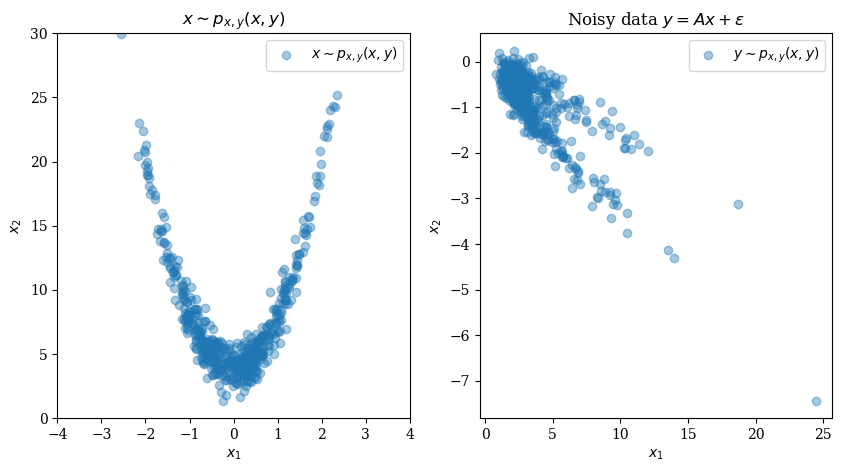

In [6]:
Y_train = reshape(A*reshape(X_train, :, n_train), nx, ny, n_in, n_train)
Y_train += .2f0*randn(Float32, nx, ny, n_in, n_train)

fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p_{x,y}(x,y)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Noisy data $y = Ax + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Training a conditional normalizing flow. 

A conditional normalizing flow is trained by learning the joint distribution $p(x,y)$ this is done in the same way as a non-conditional normalizing flow is trained my minimizing the negative log likelihood (Refer to Tutorial notebook 01 for more details. )

In [7]:
function loss(H, X, Y)
    batch_size = size(X)[end] 
    
    Zx, Zy, lgdet = H.forward(X, Y)
    l2_loss = 0.5*norm(tensor_cat(Zx, Zy))^2 / batch_size  #likelihood under Normal Gaussian training 
    
    #gradients under Normal Gaussian training
    dZx = Zx / batch_size 
    dZy = Zy / batch_size 
    
    H.backward(dZx, dZy, Zx, Zy) #sets gradients of G wrt output and also logdet terms
    
    return (l2_loss, lgdet)
end

loss (generic function with 1 method)

In [8]:
# Define network

n_hidden = 64
batchsize = 64
depth = 10

# Construct HINT network
H = NetworkConditionalHINT(n_in, n_hidden, depth; k1=1, k2=1, p1=0, p2=0)

# Training
maxiter = 900
lr      = 5f-4
lr_decay_step = 90

#compose adam optimizer with exponential learning rate decay 
opt = Flux.Optimiser(ExpDecay(lr, .9f0, lr_decay_step, 1f-6), Flux.ADAM(lr))

loss_l2_list    = zeros(maxiter)
loss_lgdet_list = zeros(maxiter)

for j=1:maxiter

    # Evaluate objective and gradients
    X = sample_banana(batchsize)
    Y = reshape(A*reshape(X, :, batchsize), nx, ny, n_in, batchsize)
    Y += .2f0*randn(Float32, nx, ny, n_in, batchsize)

    losses = loss(H, X, Y)
    loss_l2_list[j]    = losses[1]
    loss_lgdet_list[j] = losses[2]
    
    print("Iter : iteration=", j, "/", maxiter, ", batch=", 
            "; f l2 = ",   loss_l2_list[j], 
            "; f lgdet = ",loss_lgdet_list[j], 
            "; f nll objective = ",loss_l2_list[j] - loss_lgdet_list[j], "\n")

    # Update params
    for p in get_params(H)
        Flux.update!(opt, p.data, p.grad)
    end
end


Iter : iteration=1/900, batch=; f l2 = 0.8873236775398254; f lgdet = -5.313183307647705; f nll objective = 6.2005069851875305
Iter : iteration=2/900, batch=; f l2 = 1.9317933320999146; f lgdet = -5.143545150756836; f nll objective = 7.0753384828567505
Iter : iteration=3/900, batch=; f l2 = 0.5652788877487183; f lgdet = -5.008665084838867; f nll objective = 5.5739439725875854
Iter : iteration=4/900, batch=; f l2 = 0.9413456916809082; f lgdet = -4.94959831237793; f nll objective = 5.890944004058838
Iter : iteration=5/900, batch=; f l2 = 1.5255944728851318; f lgdet = -4.760295867919922; f nll objective = 6.285890340805054
Iter : iteration=6/900, batch=; f l2 = 1.0569976568222046; f lgdet = -4.578118801116943; f nll objective = 5.635116457939148
Iter : iteration=7/900, batch=; f l2 = 1.0323554277420044; f lgdet = -4.441495895385742; f nll objective = 5.473851323127747
Iter : iteration=8/900, batch=; f l2 = 0.7157586812973022; f lgdet = -4.363487720489502; f nll objective = 5.07924640178680

Iter : iteration=66/900, batch=; f l2 = 1.6824405193328857; f lgdet = 0.6647324562072754; f nll objective = 1.0177080631256104
Iter : iteration=67/900, batch=; f l2 = 2.0222573280334473; f lgdet = 0.6058576107025146; f nll objective = 1.4163997173309326
Iter : iteration=68/900, batch=; f l2 = 1.2799508571624756; f lgdet = 0.8617379665374756; f nll objective = 0.418212890625
Iter : iteration=69/900, batch=; f l2 = 1.6632648706436157; f lgdet = 0.5080239772796631; f nll objective = 1.1552408933639526
Iter : iteration=70/900, batch=; f l2 = 2.2400827407836914; f lgdet = 0.7772138118743896; f nll objective = 1.4628689289093018
Iter : iteration=71/900, batch=; f l2 = 1.7924737930297852; f lgdet = 0.7936692237854004; f nll objective = 0.9988045692443848
Iter : iteration=72/900, batch=; f l2 = 2.6926331520080566; f lgdet = 0.6234228610992432; f nll objective = 2.0692102909088135
Iter : iteration=73/900, batch=; f l2 = 1.8348462581634521; f lgdet = 0.04075479507446289; f nll objective = 1.7940

Iter : iteration=131/900, batch=; f l2 = 2.6696081161499023; f lgdet = 1.669198751449585; f nll objective = 1.0004093647003174
Iter : iteration=132/900, batch=; f l2 = 2.0250139236450195; f lgdet = 1.1340844631195068; f nll objective = 0.8909294605255127
Iter : iteration=133/900, batch=; f l2 = 1.7269331216812134; f lgdet = 1.0157673358917236; f nll objective = 0.7111657857894897
Iter : iteration=134/900, batch=; f l2 = 1.6257147789001465; f lgdet = 0.96923828125; f nll objective = 0.6564764976501465
Iter : iteration=135/900, batch=; f l2 = 2.0862698554992676; f lgdet = 1.132788896560669; f nll objective = 0.9534809589385986
Iter : iteration=136/900, batch=; f l2 = 1.8908084630966187; f lgdet = 1.3518025875091553; f nll objective = 0.5390058755874634
Iter : iteration=137/900, batch=; f l2 = 1.942064881324768; f lgdet = 0.9599940776824951; f nll objective = 0.982070803642273
Iter : iteration=138/900, batch=; f l2 = 1.6868979930877686; f lgdet = 1.262497901916504; f nll objective = 0.424

Iter : iteration=195/900, batch=; f l2 = 1.6738685369491577; f lgdet = 1.7838850021362305; f nll objective = -0.11001646518707275
Iter : iteration=196/900, batch=; f l2 = 1.6826084852218628; f lgdet = 1.8351073265075684; f nll objective = -0.15249884128570557
Iter : iteration=197/900, batch=; f l2 = 2.0852200984954834; f lgdet = 1.7340397834777832; f nll objective = 0.3511803150177002
Iter : iteration=198/900, batch=; f l2 = 1.7344714403152466; f lgdet = 1.9448413848876953; f nll objective = -0.21036994457244873
Iter : iteration=199/900, batch=; f l2 = 1.9370683431625366; f lgdet = 1.9655042886734009; f nll objective = -0.028435945510864258
Iter : iteration=200/900, batch=; f l2 = 2.208523988723755; f lgdet = 2.3841633796691895; f nll objective = -0.17563939094543457
Iter : iteration=201/900, batch=; f l2 = 2.2244246006011963; f lgdet = 2.218646764755249; f nll objective = 0.005777835845947266
Iter : iteration=202/900, batch=; f l2 = 2.1992862224578857; f lgdet = 2.132091999053955; f n

Iter : iteration=259/900, batch=; f l2 = 2.104663848876953; f lgdet = 1.9565186500549316; f nll objective = 0.14814519882202148
Iter : iteration=260/900, batch=; f l2 = 1.8498070240020752; f lgdet = 2.30137038230896; f nll objective = -0.45156335830688477
Iter : iteration=261/900, batch=; f l2 = 1.9252710342407227; f lgdet = 2.0352895259857178; f nll objective = -0.11001849174499512
Iter : iteration=262/900, batch=; f l2 = 2.1495561599731445; f lgdet = 1.8731026649475098; f nll objective = 0.27645349502563477
Iter : iteration=263/900, batch=; f l2 = 1.899580955505371; f lgdet = 1.702704668045044; f nll objective = 0.19687628746032715
Iter : iteration=264/900, batch=; f l2 = 1.966189980506897; f lgdet = 2.1649527549743652; f nll objective = -0.19876277446746826
Iter : iteration=265/900, batch=; f l2 = 1.5535093545913696; f lgdet = 1.8180460929870605; f nll objective = -0.2645367383956909
Iter : iteration=266/900, batch=; f l2 = 1.7074902057647705; f lgdet = 1.8516886234283447; f nll obj

Iter : iteration=323/900, batch=; f l2 = 2.0748374462127686; f lgdet = 2.3141331672668457; f nll objective = -0.23929572105407715
Iter : iteration=324/900, batch=; f l2 = 1.757416844367981; f lgdet = 2.069639205932617; f nll objective = -0.31222236156463623
Iter : iteration=325/900, batch=; f l2 = 1.9511842727661133; f lgdet = 2.226701259613037; f nll objective = -0.27551698684692383
Iter : iteration=326/900, batch=; f l2 = 1.828863501548767; f lgdet = 2.309992551803589; f nll objective = -0.4811290502548218
Iter : iteration=327/900, batch=; f l2 = 1.761515498161316; f lgdet = 2.208242654800415; f nll objective = -0.4467271566390991
Iter : iteration=328/900, batch=; f l2 = 1.7408826351165771; f lgdet = 2.475405693054199; f nll objective = -0.7345230579376221
Iter : iteration=329/900, batch=; f l2 = 1.8695330619812012; f lgdet = 2.5436060428619385; f nll objective = -0.6740729808807373
Iter : iteration=330/900, batch=; f l2 = 2.367544174194336; f lgdet = 2.196493148803711; f nll objecti

Iter : iteration=387/900, batch=; f l2 = 1.6213114261627197; f lgdet = 2.1781725883483887; f nll objective = -0.556861162185669
Iter : iteration=388/900, batch=; f l2 = 1.6489266157150269; f lgdet = 2.1430883407592773; f nll objective = -0.4941617250442505
Iter : iteration=389/900, batch=; f l2 = 2.047287702560425; f lgdet = 1.9977428913116455; f nll objective = 0.0495448112487793
Iter : iteration=390/900, batch=; f l2 = 1.7202801704406738; f lgdet = 2.323621988296509; f nll objective = -0.603341817855835
Iter : iteration=391/900, batch=; f l2 = 2.1829049587249756; f lgdet = 2.6668901443481445; f nll objective = -0.48398518562316895
Iter : iteration=392/900, batch=; f l2 = 1.8310694694519043; f lgdet = 2.172636032104492; f nll objective = -0.3415665626525879
Iter : iteration=393/900, batch=; f l2 = 1.6481961011886597; f lgdet = 2.4626927375793457; f nll objective = -0.814496636390686
Iter : iteration=394/900, batch=; f l2 = 1.6346181631088257; f lgdet = 2.2803127765655518; f nll object

Iter : iteration=451/900, batch=; f l2 = 1.789686918258667; f lgdet = 2.399259090423584; f nll objective = -0.609572172164917
Iter : iteration=452/900, batch=; f l2 = 2.45766019821167; f lgdet = 2.744853973388672; f nll objective = -0.28719377517700195
Iter : iteration=453/900, batch=; f l2 = 2.0094430446624756; f lgdet = 2.6053171157836914; f nll objective = -0.5958740711212158
Iter : iteration=454/900, batch=; f l2 = 2.239278793334961; f lgdet = 2.8268446922302246; f nll objective = -0.5875658988952637
Iter : iteration=455/900, batch=; f l2 = 1.7084025144577026; f lgdet = 2.503765106201172; f nll objective = -0.7953625917434692
Iter : iteration=456/900, batch=; f l2 = 2.1656875610351562; f lgdet = 2.415100336074829; f nll objective = -0.24941277503967285
Iter : iteration=457/900, batch=; f l2 = 1.278478980064392; f lgdet = 2.3338353633880615; f nll objective = -1.0553563833236694
Iter : iteration=458/900, batch=; f l2 = 1.6442705392837524; f lgdet = 2.425090789794922; f nll objective

Iter : iteration=515/900, batch=; f l2 = 2.187513828277588; f lgdet = 2.5464789867401123; f nll objective = -0.3589651584625244
Iter : iteration=516/900, batch=; f l2 = 1.7084038257598877; f lgdet = 2.595426321029663; f nll objective = -0.8870224952697754
Iter : iteration=517/900, batch=; f l2 = 1.7590274810791016; f lgdet = 2.5132248401641846; f nll objective = -0.754197359085083
Iter : iteration=518/900, batch=; f l2 = 1.7146109342575073; f lgdet = 2.5517170429229736; f nll objective = -0.8371061086654663
Iter : iteration=519/900, batch=; f l2 = 1.861572027206421; f lgdet = 2.5395305156707764; f nll objective = -0.6779584884643555
Iter : iteration=520/900, batch=; f l2 = 1.7595322132110596; f lgdet = 2.5542874336242676; f nll objective = -0.794755220413208
Iter : iteration=521/900, batch=; f l2 = 1.669097661972046; f lgdet = 2.5333545207977295; f nll objective = -0.8642568588256836
Iter : iteration=522/900, batch=; f l2 = 1.9801172018051147; f lgdet = 2.8381857872009277; f nll object

Iter : iteration=579/900, batch=; f l2 = 2.097856283187866; f lgdet = 2.693575859069824; f nll objective = -0.595719575881958
Iter : iteration=580/900, batch=; f l2 = 1.7226653099060059; f lgdet = 2.8077638149261475; f nll objective = -1.0850985050201416
Iter : iteration=581/900, batch=; f l2 = 1.9874600172042847; f lgdet = 2.5645413398742676; f nll objective = -0.5770813226699829
Iter : iteration=582/900, batch=; f l2 = 1.781040906906128; f lgdet = 2.7017698287963867; f nll objective = -0.9207289218902588
Iter : iteration=583/900, batch=; f l2 = 1.964406967163086; f lgdet = 2.7613234519958496; f nll objective = -0.7969164848327637
Iter : iteration=584/900, batch=; f l2 = 2.418001651763916; f lgdet = 2.5748229026794434; f nll objective = -0.15682125091552734
Iter : iteration=585/900, batch=; f l2 = 2.320739507675171; f lgdet = 2.5251355171203613; f nll objective = -0.20439600944519043
Iter : iteration=586/900, batch=; f l2 = 1.8452774286270142; f lgdet = 2.423430919647217; f nll object

Iter : iteration=643/900, batch=; f l2 = 2.657492160797119; f lgdet = 2.7026801109313965; f nll objective = -0.045187950134277344
Iter : iteration=644/900, batch=; f l2 = 1.8435410261154175; f lgdet = 2.915144681930542; f nll objective = -1.0716036558151245
Iter : iteration=645/900, batch=; f l2 = 2.3085532188415527; f lgdet = 2.7902073860168457; f nll objective = -0.48165416717529297
Iter : iteration=646/900, batch=; f l2 = 1.9480682611465454; f lgdet = 2.6700291633605957; f nll objective = -0.7219609022140503
Iter : iteration=647/900, batch=; f l2 = 2.0147433280944824; f lgdet = 2.561983823776245; f nll objective = -0.5472404956817627
Iter : iteration=648/900, batch=; f l2 = 2.0697927474975586; f lgdet = 2.551670551300049; f nll objective = -0.48187780380249023
Iter : iteration=649/900, batch=; f l2 = 1.9837249517440796; f lgdet = 2.700836658477783; f nll objective = -0.7171117067337036
Iter : iteration=650/900, batch=; f l2 = 1.971733570098877; f lgdet = 2.6871986389160156; f nll ob

Iter : iteration=707/900, batch=; f l2 = 1.6623449325561523; f lgdet = 2.647991180419922; f nll objective = -0.9856462478637695
Iter : iteration=708/900, batch=; f l2 = 1.8187545537948608; f lgdet = 2.477071762084961; f nll objective = -0.6583172082901001
Iter : iteration=709/900, batch=; f l2 = 1.8640261888504028; f lgdet = 2.6578094959259033; f nll objective = -0.7937833070755005
Iter : iteration=710/900, batch=; f l2 = 1.9215681552886963; f lgdet = 2.7872419357299805; f nll objective = -0.8656737804412842
Iter : iteration=711/900, batch=; f l2 = 2.132349967956543; f lgdet = 2.849548578262329; f nll objective = -0.7171986103057861
Iter : iteration=712/900, batch=; f l2 = 1.8105565309524536; f lgdet = 2.8006579875946045; f nll objective = -0.9901014566421509
Iter : iteration=713/900, batch=; f l2 = 1.6523125171661377; f lgdet = 2.794260025024414; f nll objective = -1.1419475078582764
Iter : iteration=714/900, batch=; f l2 = 2.0228404998779297; f lgdet = 2.789217472076416; f nll object

Iter : iteration=771/900, batch=; f l2 = 2.704817533493042; f lgdet = 2.5512046813964844; f nll objective = 0.15361285209655762
Iter : iteration=772/900, batch=; f l2 = 2.54738712310791; f lgdet = 2.7976698875427246; f nll objective = -0.25028276443481445
Iter : iteration=773/900, batch=; f l2 = 2.243685245513916; f lgdet = 2.9294557571411133; f nll objective = -0.6857705116271973
Iter : iteration=774/900, batch=; f l2 = 1.9405874013900757; f lgdet = 3.032855987548828; f nll objective = -1.0922685861587524
Iter : iteration=775/900, batch=; f l2 = 2.2811622619628906; f lgdet = 2.8240389823913574; f nll objective = -0.5428767204284668
Iter : iteration=776/900, batch=; f l2 = 2.9542806148529053; f lgdet = 2.7984588146209717; f nll objective = 0.1558218002319336
Iter : iteration=777/900, batch=; f l2 = 2.003710985183716; f lgdet = 3.0331778526306152; f nll objective = -1.0294668674468994
Iter : iteration=778/900, batch=; f l2 = 2.1209654808044434; f lgdet = 2.9380080699920654; f nll object

Iter : iteration=835/900, batch=; f l2 = 1.7963027954101562; f lgdet = 2.7095038890838623; f nll objective = -0.913201093673706
Iter : iteration=836/900, batch=; f l2 = 1.783115267753601; f lgdet = 2.713921546936035; f nll objective = -0.9308062791824341
Iter : iteration=837/900, batch=; f l2 = 1.5758863687515259; f lgdet = 2.5493807792663574; f nll objective = -0.9734944105148315
Iter : iteration=838/900, batch=; f l2 = 1.9602890014648438; f lgdet = 2.4739413261413574; f nll objective = -0.5136523246765137
Iter : iteration=839/900, batch=; f l2 = 1.883117914199829; f lgdet = 2.6579651832580566; f nll objective = -0.7748472690582275
Iter : iteration=840/900, batch=; f l2 = 1.9646366834640503; f lgdet = 2.813387870788574; f nll objective = -0.8487511873245239
Iter : iteration=841/900, batch=; f l2 = 2.199359178543091; f lgdet = 2.853041648864746; f nll objective = -0.6536824703216553
Iter : iteration=842/900, batch=; f l2 = 2.1892964839935303; f lgdet = 2.770216941833496; f nll objectiv

Iter : iteration=900/900, batch=; f l2 = 2.328211784362793; f lgdet = 2.923295736312866; f nll objective = -0.5950839519500732


## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $Zx, Zy = H_{\theta}(Z,Y)$ with qq plots 
- as a heuristic simply observe $Zx, Zy = H_{\theta}(X, Y)$ until it looks normal under the eyeball norm. 

Note: joint distributions are harder to learn than marginal distributions. There are a few reasons including the larger dimensionality and the fact that learning a joint distribution implicitly also learns a conditional distribution. 

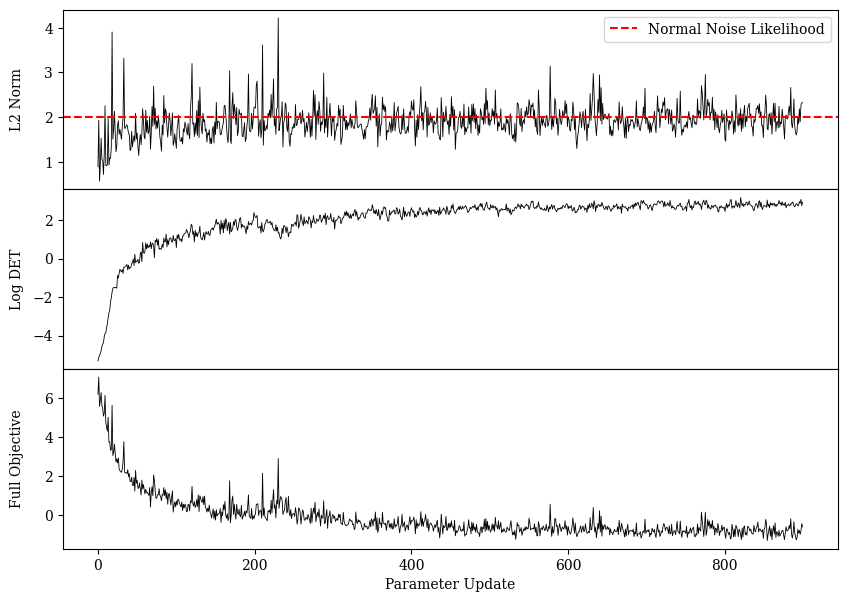

PyObject Text(0.5, 24.000000000000007, 'Parameter Update')

In [21]:
gt_l2 = 0.5*nx*ny*n_in*2 #l2 norm of noise. Note: extra 2 factor since learning a 2 rv. joint distribution

fig, axs = subplots(3, 1, sharex=true, figsize=(10,7))
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.05, 0.5)
axs[1].legend()

axs[2].plot(loss_lgdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("Log DET") 
axs[2].yaxis.set_label_coords(-0.05, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.05, 0.5)
axs[3].set_xlabel("Parameter Update") 

## Testing a Conditional Normalizing Flow 

The first step in testing a normalizing flow is to understand what prior it has learned. In this case, we trained our network to generate samples from a joint distribution so we will first check that these generative samples look like 
 
We start with normal gaussian variables $Zx, Zy \sim N(0, I)$

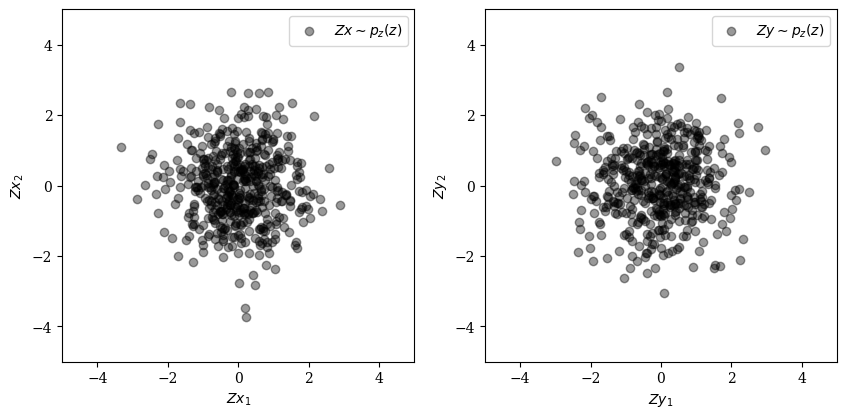

In [10]:
num_test_samples = 500;
Zx_test = randn(Float32,nx,ny,n_in, num_test_samples);
Zy_test = randn(Float32,nx,ny,n_in, num_test_samples);

fig = figure(figsize=(10,5)); 
ax1 = subplot(1,2,1)
scatter(Zx_test[1,1,1,:], Zx_test[1,1,2,:]; alpha=0.4, color="black", label = L"Zx \sim p_{z}(z)");
xlabel(L"Zx_1"); ylabel(L"Zx_2"); xlim(-5,5); ylim(-5,5);
legend(); ax1.set_aspect(1);

ax2 = subplot(1,2,2)
scatter(Zy_test[1,1,1,:], Zy_test[1,1,2,:]; alpha=0.4, color="black", label = L"Zy \sim p_{z}(z)");
xlabel(L"Zy_1"); ylabel(L"Zy_2"); xlim(-5,5); ylim(-5,5);
legend(); ax2.set_aspect(1);

Make generative samples from the joint distribution by passing both Z variables through the inverse network $ x,  y = H^{-1}_\theta(Zx,Zy)$ 

In [11]:
X_test, Y_test = H.inverse(Zx_test, Zy_test);

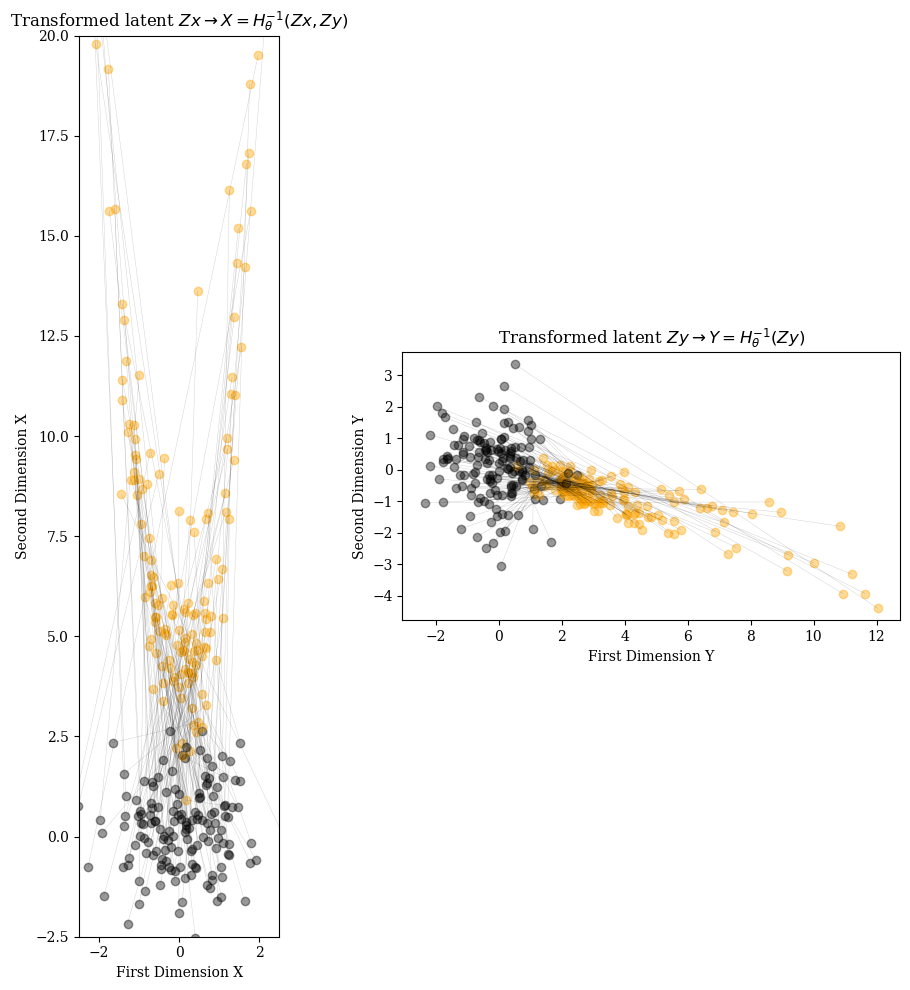

In [12]:
trans_num = 150
start_points = [(Zx_test[1,1,1,i], Zx_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:trans_num]

# Plot transformed Latent Zx
fig = figure(figsize=(10,10));
ax = fig.add_subplot(1,2,1); title(L"Transformed latent $Zx \rightarrow X=H^{-1}_\theta(Zx, Zy)$");

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension X"); ylabel("Second Dimension X");
ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

# Plot transformed Latent Zy
start_points = [(Zy_test[1,1,1,i], Zy_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(Y_test[1,1,1,i], Y_test[1,1,2,i]) for i in 1:trans_num]

ax = fig.add_subplot(1,2,2); title(L"Transformed latent $Zy \rightarrow Y=H^{-1}_\theta(Zy)$");
for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension Y"); ylabel("Second Dimension Y");
ax.set_aspect(1)

tight_layout()

Visually compare generative joint samples with joint samples from the ground truth density $x, y \sim p(x,y) $

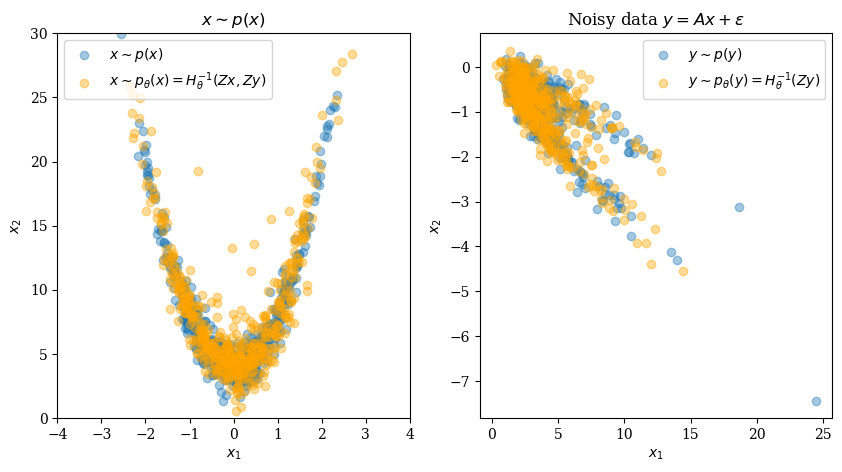

In [13]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p(x)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x)");
scatter(X_test[1,1,1,1:plot_num], X_test[1,1,2,1:plot_num]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = H_\theta^{-1}(Zx, Zy)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Noisy data $y = Ax + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(y)");
scatter(Y_test[1,1,1,1:plot_num], Y_test[1,1,2,1:plot_num]; alpha=0.4, color="orange", label = L"y \sim p_{\theta}(y) = H_\theta^{-1}(Zy)");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Test inference of inverse problem given noisy data

After verifying that training was successful we can proceed to perform inference of the inverse problem. We will first observe a single data $y$:

In [14]:
x_star  = sample_banana(1);
y_obs = reshape(A*vec(x_star), nx, ny, n_in, 1);
y_obs += .2f0*randn(Float32, size(y_obs));

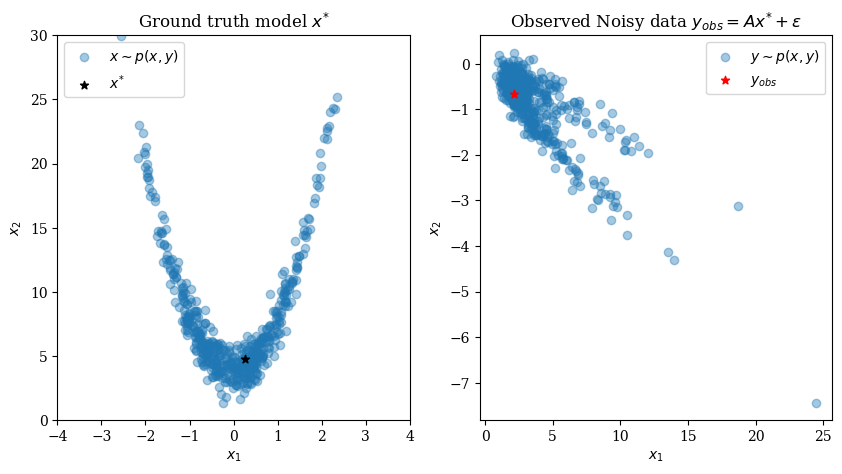

In [15]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Form conditional distribution given observed data $p(x|y_{obs})$

Remember that the y-lane in HINT is completely independent of the x-lane. This functionality is implemented in  ``H.forward_Y`` which we will call on our observed data to get the corresponding latent variable $z_y$.


In [16]:
zy_fixed = H.forward_Y(y_obs);

Then we can sample directly from the conditional aka posterior distribution $x \sim p(x|y_{obs})$ We do this by resampling $z_x \sim N(0,I)$ and calling the inverse network $H^{-1}(z_x, z_y)$

In [17]:
#fix zy and resample zx many times to generate samples from the conditional distribution p(x|y)
cond_sampling_size = 50
Zx = randn(Float32, nx, ny, n_in, cond_sampling_size)
X_post = H.inverse(Zx, zy_fixed.*ones(Float32, nx, ny, n_in, cond_sampling_size))[1];

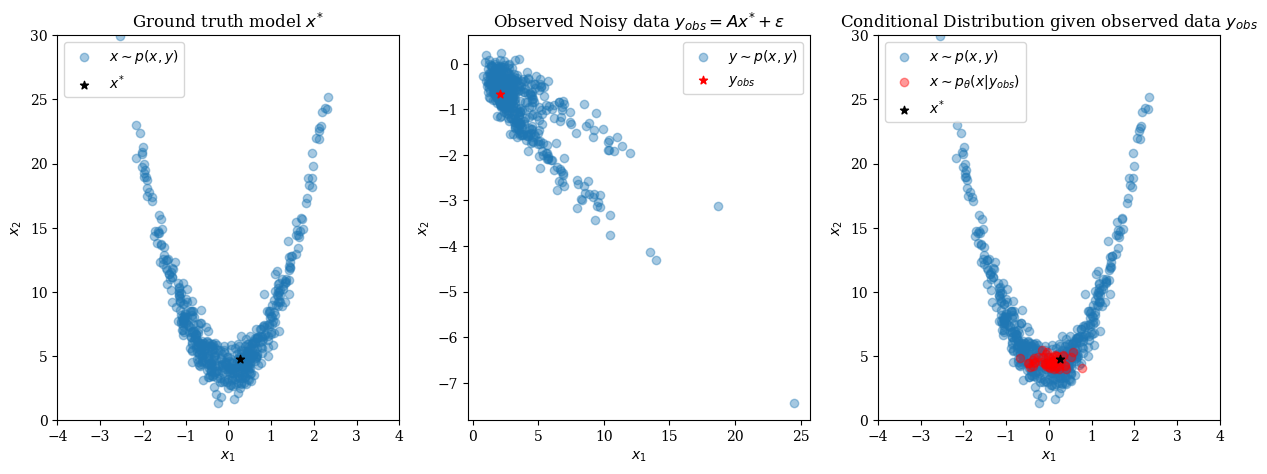

PyObject <matplotlib.legend.Legend object at 0x17eadd520>

In [18]:
fig = figure(figsize=(15,5)); 
subplot(1,3,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,3,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

subplot(1,3,3); title(L"Conditional Distribution given observed data $y_{obs}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(X_post[1,1,1,:], X_post[1,1,2,:]; alpha=0.4, color="red", label = L"x \sim p_{\theta}(x | y_{obs})");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*",color="black",  label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend()